# Intraday Return Forecasting with Time Series Models

This notebook demonstrates how to predict intraday returns using ARIMA models, and how to evaluate the predictions. It also shows how to model volatility using GARCH, which is better suited for capturing time-varying variance (volatility clustering) in financial data.


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import seaborn as sns
from sklearn.metrics import root_mean_squared_error, mean_absolute_error


# Reading the Data

In [156]:
df = pd.read_csv("dataFiles/TATASTEEL_cleaned.csv")

# Basic Data Cleaning

In [157]:
df = df[['Date','Open','Close']]
df['Date'] = pd.to_datetime(df['Date'], utc = True)
df.info()
df['IntradayReturn'] = np.log(df['Close'] / df['Open'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7383 entries, 0 to 7382
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   Date    7383 non-null   datetime64[ns, UTC]
 1   Open    7383 non-null   float64            
 2   Close   7383 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(2)
memory usage: 173.2 KB


In [158]:
# df = df.set_index('Date')
print(df.head())

# df.dropna(inplace=True)
# df.shape

                       Date      Open     Close  IntradayReturn
0 1995-12-31 18:30:00+00:00  2.434930  2.437989        0.001255
1 1996-01-01 18:30:00+00:00  2.434930  2.392717       -0.017489
2 1996-01-02 18:30:00+00:00  2.392716  2.393328        0.000256
3 1996-01-03 18:30:00+00:00  2.355398  2.317467       -0.016235
4 1996-01-04 18:30:00+00:00  2.289325  2.271582       -0.007780


# Calculating Return

In [159]:
df['LogClose'] = np.log(df['Close']) 

df['Return'] =  df['Close'] - df['Open'] 
# df['LogReturn'] = np.log(df['Return']) 

df.head()
df3 = df.tail(6000)

In [160]:
# df2 = df2.set_index('Date')
# df3 = df2.resample('ME').last()
# df3 = df2

In [161]:
df3.head()

,Date,Open,Close,IntradayReturn,LogClose,Return
1383,2001-04-18 18:30:00+00:00,1.747779,1.818164,0.039481,0.597827,0.070385
1384,2001-04-19 18:30:00+00:00,1.827373,1.762251,-0.036288,0.566592,-0.065122
1385,2001-04-22 18:30:00+00:00,1.774749,1.781327,0.003700,0.577359,0.006578
1386,2001-04-23 18:30:00+00:00,1.762909,1.778038,0.008546,0.575511,0.015130
1387,2001-04-24 18:30:00+00:00,1.801062,1.922097,0.065041,0.653417,0.121035


# Plots over time


<Axes: xlabel='Date', ylabel='Return'>

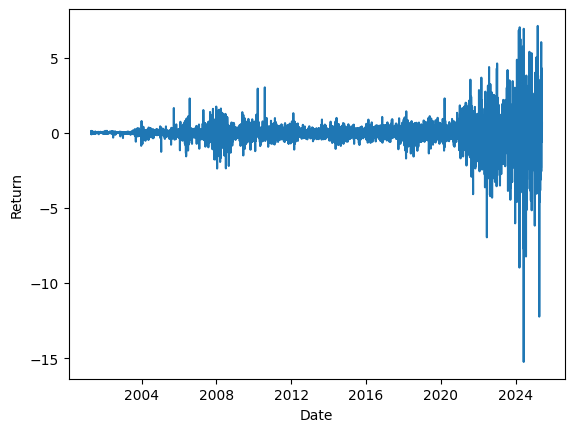

In [162]:
sns.lineplot(data = df3, x = "Date", y = "Return")

<Axes: xlabel='Date', ylabel='IntradayReturn'>

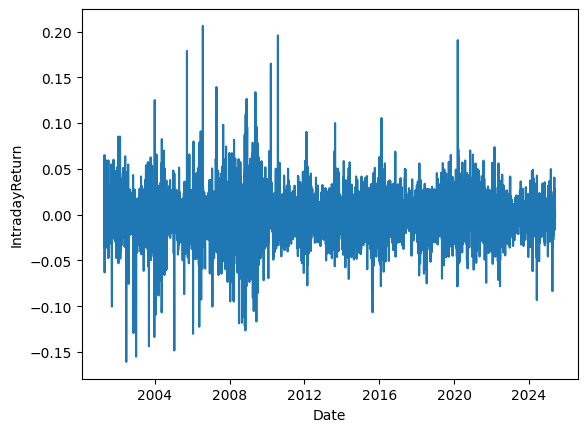

In [163]:
sns.lineplot(data=df3, x="Date", y="IntradayReturn")

<Axes: xlabel='Date', ylabel='Close'>

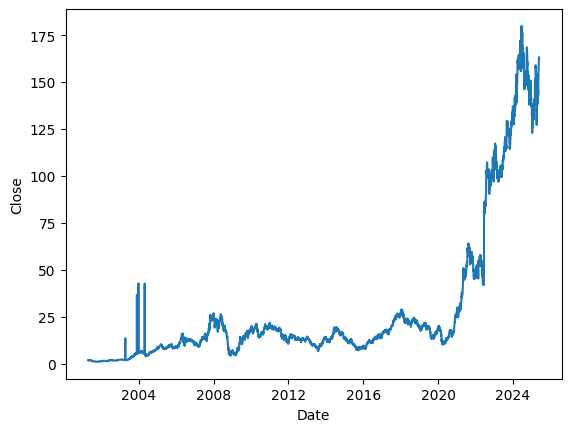

In [164]:
sns.lineplot(data=df3, x="Date", y="Close")

<Axes: xlabel='Date', ylabel='LogClose'>

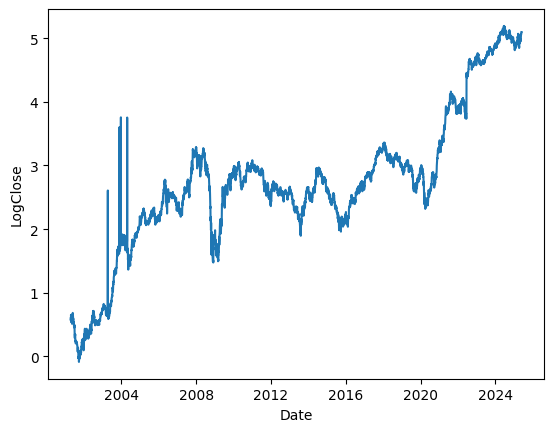

In [165]:
sns.lineplot(data=df3, x="Date", y="LogClose")

# ACF and PACF

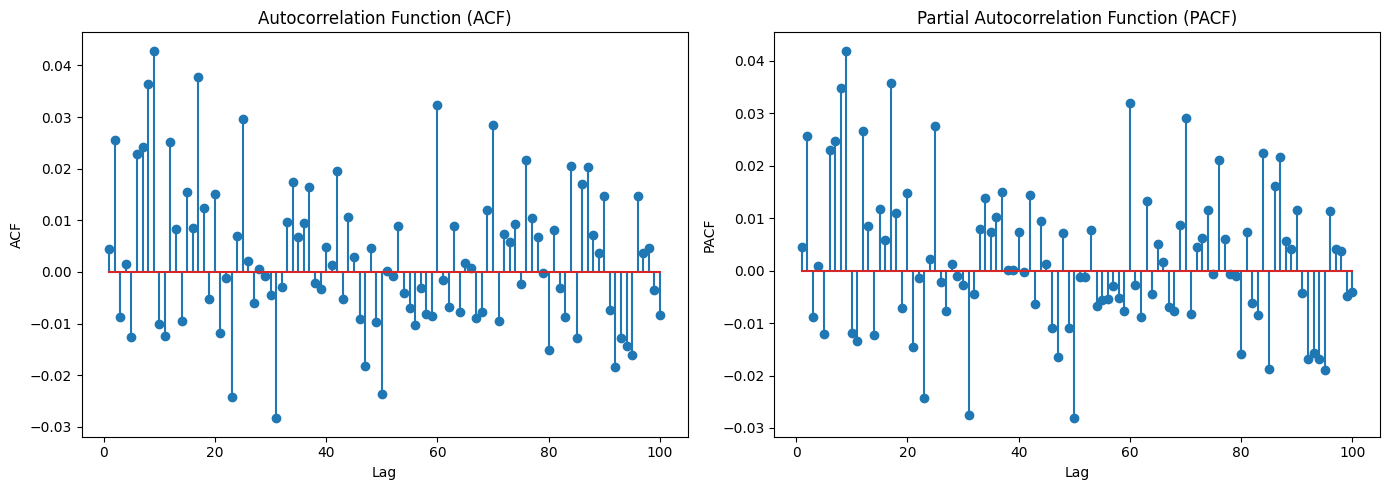

In [166]:
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt
import numpy as np

# Series without NaNs
series = df3['IntradayReturn'].dropna()

# Compute ACF and PACF values excluding lag 0
acf_vals = acf(series, nlags=100)[1:]      # Exclude lag 0
pacf_vals = pacf(series, nlags=100, method='ywm')[1:]  # Exclude lag 0

lags = np.arange(1, 101)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].stem(lags, acf_vals)
axes[0].set_title('Autocorrelation Function (ACF)')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('ACF')

axes[1].stem(lags, pacf_vals)
axes[1].set_title('Partial Autocorrelation Function (PACF)')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('PACF')

plt.tight_layout()
plt.show()


# Augmented Dickey Fuller

In [167]:
from statsmodels.tsa.stattools import adfuller

# Assuming df['Close'] contains your time series
result = adfuller(df['Close'].dropna())

# Print the test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Used lags:', result[2])
print('Number of observations:', result[3])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')


ADF Statistic: 2.4003969141539443
p-value: 0.9990104962897183
Used lags: 30
Number of observations: 7352
Critical Values:
   1%: -3.4312397694039465
   5%: -2.861933209553657
   10%: -2.5669793011524624


In [168]:
from statsmodels.tsa.stattools import adfuller

# Assuming df['Close'] contains your time series
result = adfuller(df['IntradayReturn'].dropna())

# Print the test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Used lags:', result[2])
print('Number of observations:', result[3])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -22.66166143400944
p-value: 0.0
Used lags: 11
Number of observations: 7371
Critical Values:
   1%: -3.4312374750732526
   5%: -2.8619321957875727
   10%: -2.5669787615097066


The p-value is 0.0 (much less than 0.05).
Thus series is stationary.

In [169]:
from statsmodels.tsa.stattools import adfuller

# Assuming df['Close'] contains your time series
result = adfuller(df['Return'].dropna())

# Print the test results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Used lags:', result[2])
print('Number of observations:', result[3])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -12.832355433539096
p-value: 5.8370922209468555e-24
Used lags: 33
Number of observations: 7349
Critical Values:
   1%: -3.4312401327515385
   5%: -2.861933370101263
   10%: -2.5669793866143524


# Load and Prepare Data

In [180]:
# df3['IntradayReturn'] = df3['IntradayReturn'] * 100
df3 = df3.tail(1000)
series = df3['Return'].dropna()
series.index = pd.to_datetime(series.index)  # Ensure datetime index
series.head()


1970-01-01 00:00:00.000006383    1.811874
1970-01-01 00:00:00.000006384   -2.179201
1970-01-01 00:00:00.000006385   -2.183329
1970-01-01 00:00:00.000006386    0.530353
1970-01-01 00:00:00.000006387    0.206364
Name: Return, dtype: float64

## Train-Test Split

In [181]:
split = int(len(series) * 0.8)
train, test = series[:split], series[split:]


## Fit ARMA Model

In [191]:
model = ARIMA(train, order=(1, 0, 1))  # We can tune order as needed here
fitted_model = model.fit()
print(fitted_model.summary())


                               SARIMAX Results                                
Dep. Variable:                 Return   No. Observations:                  800
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1596.074
Date:                Mon, 09 Jun 2025   AIC                           3200.149
Time:                        15:14:11   BIC                           3218.887
Sample:                    01-01-1970   HQIC                          3207.347
                         - 01-01-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2223      0.064     -3.472      0.001      -0.348      -0.097
ar.L1         -0.8120      0.104     -7.836      0.000      -1.015      -0.609
ma.L1          0.7609      0.113      6.711      0.0

/Users/ankuryadav/Downloads/data-iitm/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
/Users/ankuryadav/Downloads/data-iitm/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)
/Users/ankuryadav/Downloads/data-iitm/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


## Forecast Intraday Returns

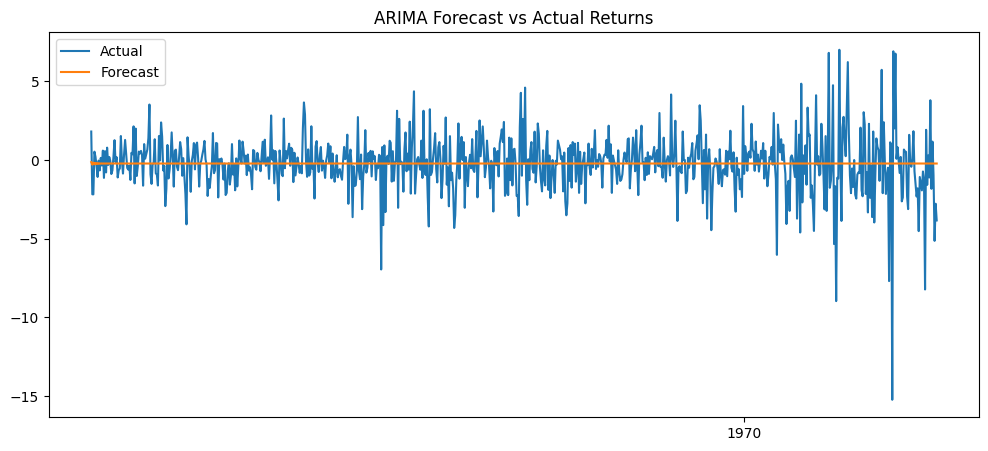

In [195]:
forecast = fitted_model.get_forecast(steps=len(train))
mean_forecast = forecast.predicted_mean

plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Actual')
plt.plot(train.index, mean_forecast, label='Forecast')
plt.legend()
plt.title('ARIMA Forecast vs Actual Returns')
plt.show()


## Evaluate Forecast

In [196]:
rmse = root_mean_squared_error(test, mean_forecast)
mae = mean_absolute_error(test, mean_forecast)
directional_accuracy = (np.sign(test) == np.sign(mean_forecast)).mean()

print(f'RMSE: {rmse:.6f}')
print(f'MAE: {mae:.6f}')
print(f'Directional Accuracy: {directional_accuracy:.2%}')


ValueError: Found input variables with inconsistent numbers of samples: [200, 800]